## Machine Learning: Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pylab as pl
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
warnings.filterwarnings('ignore')
linkname = 'bank_cleaned.csv'
dataset = pd.read_csv(linkname)
dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [2]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary,month_int,age_group,balance_group
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0,5.0,50.0,average balance
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0,5.0,40.0,low balance
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0,5.0,30.0,low balance
3,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0,5.0,30.0,low balance
4,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0,5.0,20.0,low balance


### Prepare Data for Classification

#### Select variables relevant to customers

The most relevant variables worth considering from this dataset are job, education, age, balance, default record, housing record, and loan record.  The rest of the columns are not worth analyzing or modeling because they are not related to the customers.

In [3]:
dataset.drop(['marital'], axis=1, inplace=True)
dataset1 = dataset.iloc[:, 0:7]

#### Transform categorical data into dummy variables

The five categorical variables (job, education, default, housing, and loan) are transformed into dummy variables.  These dummy variables are used because categorical variables are not ordinal (numeric).  These variables represent different types rather than levels, so dummy variables are introduced to distinguish the effect of different categories.

In [4]:
dataset2 = pd.get_dummies(dataset1, columns=['job'])
dataset2 = pd.get_dummies(dataset2, columns=['education'])
dataset2['housing'] = dataset2['housing'].map({'yes': 1, 'no': 0})
dataset2['default'] = dataset2['default'].map({'yes': 1, 'no': 0})
dataset2['loan'] = dataset2['loan'].map({'yes': 1, 'no': 0})
dataset_response = pd.DataFrame(dataset['response_binary'])
dataset2 = pd.merge(dataset2, dataset_response, left_index=True, right_index=True)

#### Feature Selection

The first 20 columns, which have the customer statistics, are selected as the features while the last column, 'campaign outcome', is the target.

In [5]:
array = dataset2.values
X = array[:, 0:-1]
Y = array[:, -1]

### Train/Test split

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

## Compare Classification Algorithms

Four different classification algorithms (Logistical Regression, K-Neighbors Classifier, Ramdom Forest Classifier, and GaussianNB) are used on the dataset and the best scoring one will be used to build the model.

In [7]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))

In [8]:
result_c = []
names_c = []
for name, model in models:
    kfold = KFold(n_splits = 10, random_state=7)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    result_c.append(cv_results)
    names_c.append(name)
    message = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(message)

LR: 0.884287 (0.006382)
KNN: 0.872674 (0.005091)
RF: 0.870505 (0.003420)
NB: 0.824577 (0.007188)


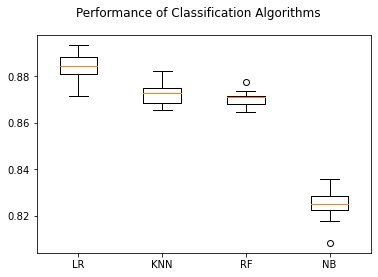

In [9]:
fig = plt.figure()
fig.suptitle('Performance of Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(result_c)
ax.set_xticklabels(names_c)
plt.show()

In [10]:
def fit_ml_algo(algo, X_train, Y_train, X_test, cv):
    model = algo.fit(X_train, Y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, KNeighborsClassifier, GaussianNB, RandomForestClassifier,))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, Y_test) * 100, 2)
    train_pred = model_selection.cross_val_predict(algo, X_train, Y_train, X_test, cv=cv, n_jobs=-1)
    acc_cv = round(metrics.accuracy_score(Y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs


In [11]:
def plot_roc_curve(Y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristics')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1], 'r--')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [12]:
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs=-1), X_train, Y_train, X_test, 10)
print(metrics.classification_report(Y_train, train_pred_log))

ValueError: Found input variables with inconsistent numbers of samples: [28588, 28588, 12253]

#### Logistic Regression is the best performing model.

The logistical regression model has the highest score (88.5%), suggesting a high level of strength of this model to classify the customer response given all of the features.

## Test LR model on test set

In [ ]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)

### Evaluate the model

In [ ]:
predictions = LR.predict(X_test)

In [ ]:
print(accuracy_score(Y_test, predictions))

Accuracy score is the percentage of correct predictions out of all of the predictions made.  This algorithm is 89.09% accurate, suggesting this model is very strong to classify the customer response given all of the defined customer features.

In [ ]:
print(confusion_matrix(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

<b>The accuracy of an algorithm can be misleading, especially if the data very unbalanced, because the number of observations in the different classes vary largely.</b>

The confustion matrix gives a breakdown of the prediction result and error types.  In the test set, the matrix proves the algorithm performed very well because most of the results (7278 true positives, 0 false positives) are the correct predictions.  However, there were 891 false negatives, which means the algorithm predicted the client would subscribed, but they did not subscribe.

The main problem revealed here is that the dataset is extremely unbalanced, with nearly all of the clients not subscribing.  This means that the accuracy score is biased, and further evaluation is needed.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions))

Be careful interpreting this report.  The precision score of 0 means that for all instances predicted as no subscription, meaning that 89% of the clients said no.  Recall is the ability of a classifier to find all of the positive values.  A Recall score of 0 in this instance means that all of the clients said no, which was 100% correct in this case.

The report shows that the LR model has great predictive power to identify the customers who would not subscribe to the term deposit.  Since there are so few clients actually subscribing to the deal, there is a need for stratified sampling or rebalancing to deal with the structual weakness of the data.  We cannot conclude that the LR algorithm can accurately classify those who are likely to subscribe.

## Machine Learning: Regression

Regression analysis is used to complement the classification results and help the bank better predict the campaign outcome based on the customer's stats.

Since the duration of a phone call is positively correlated with the outcome, it can serve as another indicator on the possibility of a subscription.  We will use regression here to find out the length of a phone call, helping the bank predict the actual subscription rate.

In [ ]:
dataset4 = dataset2.drop(['response_binary'], axis=1)
dataset4['duration'] = dataset['duration']

In [ ]:
array = dataset4.values
X = array[:,0:20]
y = array[:,20]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', DecisionTreeRegressor()))

In [ ]:
result_e2 = []
names_e2 = []
for name, model in models:
    kfold = KFold(n_splits = 10, random_state=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    result_e2.append(cv_results)
    names_e2.append(name)
    message = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(message)

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.boxplot(result_e2)
fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2)
plt.show()

Ridge regression slightly outperforms other models.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()), ('LASSO', Lasso())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()), ('RIDGE', Ridge())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()), ('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeRegressor())])))

In [ ]:
result_e2_normalized = []
names_e2_normalized = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    result_e2_normalized.append(cv_results)
    names_e2_normalized.append(name)
    message = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(message)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plt.boxplot(result_e2_normalized)
fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2_normalized)
plt.show()

After standardization, ridge regression is still the best-performing model.

In [ ]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predicted_y = ridge.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
print('The mean squared error is: ', mean_squared_error(y_test, predicted_y))

The length of the duration is extremely varied from 0.1 to 81.97 minutes.  A MSE of 17.78 means that the ridge regression is a sound model in predicting the target variable and suggests that the bank can estimate the duration of a campaign calls of each client using the customer's profile.